In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

## I. Load related data

In [2]:
listings = pd.read_csv("data/listings.csv.gz")
reviews = pd.read_csv("data/reviews.csv.gz")

## II. Data inspections

In [3]:
long_content_cols = ["description", "neighborhood_overview", "picture_url", 
                     "host_url", "host_about", "host_thumbnail_url", "host_picture_url"]
listings.drop(long_content_cols, axis=1).head()

,id,listing_url,scrape_id,last_scraped,name,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20201223070513,2020-12-23,Ocean front condo on the sand,8435,Jef Karchin,2009-02-23,"San Diego, California, United States",within a few hours,100%,100%,f,Mission Beach,3.0,3.0,"['email', 'phone', 'kba']",t,t,"San Diego, California, United States",Mission Bay,NaN,32.78430,-117.25258,Entire condominium,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""Iron"", ""Elevator"", ""Stove"", ""Microwave"", ""Di...","$2,050.00",3,365,3.0,3.0,365.0,365.0,3.0,365.0,NaN,t,6,21,44,207,2020-12-23,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
1,29967,https://www.airbnb.com/rooms/29967,20201223070513,2020-12-23,"Great home, 10 min walk to Beach",129123,Michael,2010-05-21,"San Diego, California, United States",within an hour,100%,50%,t,Pacific Beach,6.0,6.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,NaN,Pacific Beach,NaN,32.80724,-117.25630,Entire bungalow,Entire home/apt,8,NaN,2 baths,2.0,3.0,"[""Iron"", ""Hot water"", ""Heating"", ""Kitchen"", ""W...",$261.00,4,365,4.0,4.0,365.0,365.0,4.0,365.0,NaN,t,6,6,6,213,2020-12-23,62,2,1,2010-07-09,2020-11-29,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,5,5,0,0,0.49
2,38245,https://www.airbnb.com/rooms/38245,20201223070513,2020-12-23,Point Loma: Den downstairs,164137,Melinda,2010-07-12,"San Diego, California, United States",within a day,100%,86%,f,Loma Portal,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"San Diego, California, United States",Roseville,NaN,32.74202,-117.21870,Private room in house,Private room,1,NaN,1 shared bath,1.0,1.0,"[""Iron"", ""Hot water"", ""Dishes and silverware"",...",$74.00,1,21,1.0,1.0,21.0,21.0,1.0,21.0,NaN,t,24,54,84,359,2020-12-23,143,0,0,2010-09-09,2019-10-20,86.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,f,3,0,3,0,1.14
3,54001,https://www.airbnb.com/rooms/54001,20201223070513,2020-12-23,"La Jolla 2 Bdr Cottage: 1 Qn; 2Twns, Blks 2 Ocn",252692,Marsha,2010-10-04,"San Diego, California, United States",within an hour,100%,75%,t,La Jolla,5.0,5.0,"['email', 'phone', 'reviews', 'kba']",t,t,"La Jolla, California, United States",La Jolla,NaN,32.81301,-117.26856,Entire guesthouse,Entire home/apt,3,NaN,1 bath,2.0,5.0,"[""Luggage dropoff allowed"", ""Single level home...",$110.00,3,365,3.0,30.0,18.0,1125.0,23.0,1079.9,NaN,t,0,0,18,99,2020-12-23,244,30,5,2011-01-04,2020-12-22,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,2,1,1,0,2.01
4,62274,https://www.airbnb.com/rooms/62274,20201223070513,2020-12-23,"charming, colorful, close to beach",302986,Isabel,2010-11-28,"San Diego, California, United States",within an hour,92%,95%,t,Pacific Beach,2.0,2.0,"['email', 'phone', 'reviews', 'kba']",t,t,"San Diego, California, United States",Pacific Beach,NaN,32.80734,-117.24243,Entire guesthouse,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Luggage dropoff allowed"",

## III. Data pre-processing

### III.1 get rid of columns with no information

In [4]:
exclude_list = [] 
for col in listings.columns:
    value_cnts = len(listings[col].unique())
    if value_cnts < 2:
        exclude_list.append(col)

# too many null values 
is_null_cnt = listings.isnull().sum()
exclude_list += list(is_null_cnt[is_null_cnt > listings.shape[0]/4].index)
exclude_list = list(set(exclude_list))
print(exclude_list)


# no for analysis
exclude_list += ["scrape_id", "host_id"]

exclude_list += ["latitude", "longitude"]


# get rid of columns
listings = listings.drop(exclude_list ,axis=1)

['host_about', 'neighbourhood', 'license', 'scrape_id', 'neighbourhood_group_cleansed', 'bathrooms', 'neighborhood_overview', 'calendar_updated']


### III.2 seperate numeric and non-numeric data and process with different methods

In [6]:
df_numeric = listings.select_dtypes(exclude=['object'])

# via data inspections
useful_cat_varibles = ["neighbourhood_cleansed", "host_identity_verified", "host_neighbourhood"]
useful_cat_varibles += ["property_type", "room_type"]
useful_cat_varibles += ["host_response_time"]
df_cat = listings[useful_cat_varibles]

description_cols = ["description", "host_about"]
ser_amenities = listings.amenities

# format parsing
Y = listings.price.str.replace("$","").str.replace(",","").astype(float)


# encode category variable into numeric one
le_dict = {}
categorical_feature = []
for col in df_cat.columns:
    le = preprocessing.LabelEncoder()
    le.fit(df_cat[col])
    le_dict[col] = le
    encoded_fts = le.transform(df_cat[col])
    df_cat[col] = encoded_fts
    categorical_feature.append(col)

df_all = pd.concat([df_numeric, df_cat], axis=1)
df_all["n_amenities"] = ser_amenities.apply(lambda x: len(eval(x)))

/Users/lucaslee/anaconda3/envs/lucas_test/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### III.3 missing data imputation

In [7]:
# show all varibles with missing data
varibles_na_cnt = df_all.isnull().sum()
print(varibles_na_cnt[varibles_na_cnt > 0])

host_listings_count               3
host_total_listings_count         3
bedrooms                        997
beds                             50
minimum_minimum_nights            1
maximum_minimum_nights            1
minimum_maximum_nights            1
maximum_maximum_nights            1
minimum_nights_avg_ntm            1
maximum_nights_avg_ntm            1
review_scores_rating           1482
review_scores_accuracy         1525
review_scores_cleanliness      1524
review_scores_checkin          1527
review_scores_communication    1525
review_scores_location         1527
review_scores_value            1527
reviews_per_month              1441
dtype: int64


In [8]:
imputer_dict = {}
for col in varibles_na_cnt[varibles_na_cnt > 0].index:
    if "review" in col:
        value_to_fill = 0
    else:
        most_freq = df_all[col].value_counts().index[0]
        value_to_fill = most_freq    
    df_all[col].fillna(value_to_fill, inplace=True)
    imputer_dict[col] = value_to_fill

## IV. Split training and testing datasets

In [9]:
X = df_all.drop(["id"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=9527)

In [10]:
X_train.head()

,host_listings_count,host_total_listings_count,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,neighbourhood_cleansed,host_identity_verified,host_neighbourhood,property_type,room_type,host_response_time,n_amenities
8358,11.0,11.0,2,1.0,1.0,7,1125,3.0,7.0,1125.0,1125.0,6.9,1125.0,0,15,45,54,5,5,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,9,9,0,0,2.03,51,1,90,6,0,3,19
8832,2.0,2.0,5,2.0,3.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,6,7,7,274,1,1,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,3,3,0,0,1.00,41,1,166,10,0,2,41
3120,35.0,35.0,4,1.0,2.0,1,365,2.0,2.0,1125.0,1125.0,2.0,1125.0,17,45,68,107,133,31,1,87.0,9.0,8.0,8.0,9.0,10.0,8.0,30,30,0,0,3.32,46,1,118,15,0,3,24
1081,1.0,1.0,2,1.0,1.0,1,14,1.0,2.0,14.0,14.0,1.3,14.0,30,60,67,67,82,13,0,95.0,10.0,10.0,10.0,10.0,10.0,9.0,1,0,1,0,1.28,69,1,166,30,2,2,51
2566,10.0,10.0,10,3.0,4.0,2,21,2.0,2.0,21.0,21.0,2.0,21.0,25,55,85,349,106,16,0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,2,1,0,1,2.53,51,1,34,20,0,3,39


## V. Model traing and Evaluation

In [11]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=None)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [12]:
print('Saving model...')
gbm.save_model('model.txt')
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Saving model...
Starting predicting...
The rmse of prediction is: 339.14092643910897


## VI. Interpretability

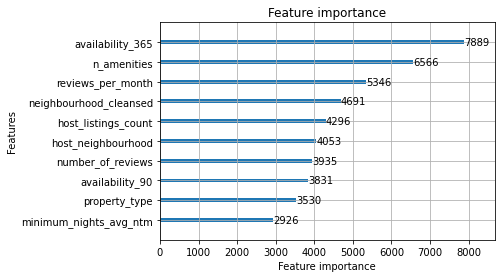

In [13]:
ax = lgb.plot_importance(gbm, max_num_features = 10)

## VII. optimizations (hyper-parameter tuning, more features)

In [ ]:
# II. hyper-parameter tunning:
## 9. CV/ grid, random search (build in k-fold)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score

reg = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

random_grid = {'max_features': max_features,
               'min_samples_leaf': min_samples_leaf}

mse_scorer = make_scorer(mean_squared_error)

grid_obj = GridSearchCV(reg, random_grid, scoring=mse_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
final_reg = grid_obj.best_estimator_
print(grid_obj.best_params_)
final_reg.fit(X_train, y_train)


### VI.2 sentiment analysis

In [25]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import tensorflow as tf

In [20]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']


In [37]:
def list_packer(l, pack_size=30):
    while l:
        l, pack = l[pack_size:], l[:pack_size]
        yield pack

In [46]:
pred_sentences = reviews.comments.tolist()
pred_sentences_batches = list_packer(pred_sentences, 100)
pred_sentences_batches = [x for x in pred_sentences_batches]

In [47]:
from tqdm.notebook import tqdm

In [ ]:
%%time
label_list = []
for ps_batch in tqdm(pred_sentences_batches):
    tf_batch = tokenizer(ps_batch, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    labels = ['Negative','Positive']
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    label_list.append(label)
# for i, s in enumerate(pred_sentences):
#     print(s, ": \n", labels[label[i]])

  0%|          | 0/4435 [00:00<?, ?it/s]

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,29967,62788,2010-07-09,151260,Debbie,When I booked our stay in San Diego at Dennis ...
1,29967,64568,2010-07-14,141552,Eric,This was my first experience with using airbnb...
2,29967,67502,2010-07-22,141591,David,We found the house to be very accommodating--e...
3,29967,70466,2010-07-29,125982,Anders,As advertised and more. Dennis was very helpfu...
4,29967,74876,2010-08-07,29835,Miyoko,We had a great time in San Diego. Denis' house...
...,...,...,...,...,...,...
443411,46995597,715948454,2020-12-16,346790349,Mike,"This is a great place with modern design, extr..."
443412,46995597,716097352,2020-12-17,370055591,Hanna,Such a amazing place! It makes me feel like ho...
443413,46995597,716330508,2020-12-18,299951196,Trina,Booked this place last minute and was able to ...
443414,46995597,716579344,2020-12-19,74213915,Colby,We had a great time staying at this house. It ...


In [75]:
reviews[reviews.listing_id == 29967].comments

0     When I booked our stay in San Diego at Dennis ...
1     This was my first experience with using airbnb...
2     We found the house to be very accommodating--e...
3     As advertised and more. Dennis was very helpfu...
4     We had a great time in San Diego. Denis' house...
                            ...                        
57    Michael’s place is great, very good location c...
58    Michaels home is spacious and clean. Was the p...
59    A very good neighborhood and house. The landlo...
60    Michael/Dennies were great hosts! Responded ve...
61          Great Location and nice for a small family.
Name: comments, Length: 62, dtype: object

In [ ]:
review_counts
review_senmentic_counts
